# Cleaning / Normalizing the thematic area

In [1]:
import pandas as pd
pd.options.display.max_colwidth = 400

In [2]:
%matplotlib inline

## Loading the dataset

In [3]:
journals = pd.read_csv("tabs_network/journals.csv")
journals.columns

Index(['extraction date', 'study unit', 'collection', 'ISSN SciELO', 'ISSN's',
       'title at SciELO', 'title thematic areas',
       'title is agricultural sciences', 'title is applied social sciences',
       'title is biological sciences', 'title is engineering',
       'title is exact and earth sciences', 'title is health sciences',
       'title is human sciences', 'title is linguistics, letters and arts',
       'title is multidisciplinary', 'title current status',
       'title + subtitle SciELO', 'short title SciELO', 'short title ISO',
       'title PubMed', 'publisher name', 'use license', 'alpha frequency',
       'numeric frequency (in months)', 'inclusion year at SciELO',
       'stopping year at SciELO', 'stopping reason',
       'date of the first document', 'volume of the first document',
       'issue of the first document', 'date of the last document',
       'volume of the last document', 'issue of the last document',
       'total of issues', 'issues at 2018', 'is

The column names aren't helping us with all the small details
like the trailing whitespaces in the latter fields.
The easiest approach to deal with them
is to run this normalization function
from the column names simplification notebook.
Applying it is straightforward, and the order of the columns is kept as is.

In [4]:
def normalize_column_title(name):
    import re
    name_unbracketed = re.sub(r".*\((.*)\)", r"\1",
                              name.replace("(in months)", "in_months"))
    words = re.sub("[^a-z0-9+_ ]", "", name_unbracketed.lower()).split()
    ignored_words = ("at", "the", "of", "and", "google", "scholar", "+")
    replacements = {
        "document": "doc",
        "documents": "docs",
        "frequency": "freq",
        "language": "lang",
    }
    return "_".join(replacements.get(word, word)
                    for word in words if word not in ignored_words) \
              .replace("title_is", "is")

In [5]:
journals.rename(columns=normalize_column_title, inplace=True)
journals.columns

Index(['extraction_date', 'study_unit', 'collection', 'issn_scielo', 'issns',
       'title_scielo', 'title_thematic_areas', 'is_agricultural_sciences',
       'is_applied_social_sciences', 'is_biological_sciences',
       'is_engineering', 'is_exact_earth_sciences', 'is_health_sciences',
       'is_human_sciences', 'is_linguistics_letters_arts',
       'is_multidisciplinary', 'title_current_status', 'title_subtitle_scielo',
       'short_title_scielo', 'short_iso', 'title_pubmed', 'publisher_name',
       'use_license', 'alpha_freq', 'numeric_freq_in_months',
       'inclusion_year_scielo', 'stopping_year_scielo', 'stopping_reason',
       'date_first_doc', 'volume_first_doc', 'issue_first_doc',
       'date_last_doc', 'volume_last_doc', 'issue_last_doc', 'total_issues',
       'issues_2018', 'issues_2017', 'issues_2016', 'issues_2015',
       'issues_2014', 'issues_2013', 'total_regular_issues',
       'regular_issues_2018', 'regular_issues_2017', 'regular_issues_2016',
       'regul

## Thematic areas

At first, it might seem that there are way too many thematic areas:

In [6]:
journals["title_thematic_areas"].unique()

array(['Applied Social Sciences', 'Health Sciences', 'Human Sciences',
       'Exact and Earth Sciences', 'Biological Sciences',
       'Agricultural Sciences',
       'Biological Sciences;Exact and Earth Sciences',
       'Engineering;Exact and Earth Sciences',
       'Agricultural Sciences;Biological Sciences',
       'Applied Social Sciences;Human Sciences', 'Engineering',
       'Health Sciences;Human Sciences',
       'Agricultural Sciences;Biological Sciences;Exact and Earth Sciences;Health Sciences',
       'Linguistics, Letters and Arts',
       'Biological Sciences;Health Sciences',
       'Agricultural Sciences;Biological Sciences;Health Sciences',
       'Agricultural Sciences;Biological Sciences;Engineering;Exact and Earth Sciences;Health Sciences;Human Sciences',
       'Agricultural Sciences;Biological Sciences;Engineering;Exact and Earth Sciences;Human Sciences',
       'Agricultural Sciences;Biological Sciences;Engineering;Health Sciences',
       'Applied Social Scienc

But, actually, there are just $8$ of them,
and what we're seeing are the several combinations of them:

In [7]:
set.union(*journals["title_thematic_areas"].str.split(";")
                                           .dropna().apply(set).values)

{'Agricultural Sciences',
 'Applied Social Sciences',
 'Biological Sciences',
 'Engineering',
 'Exact and Earth Sciences',
 'Health Sciences',
 'Human Sciences',
 'Linguistics, Letters and Arts',
 'Psicanalise'}

The `Psicanalise` isn't a thematic area,
it appears in the `psi` collection,
which is independent
(i.e., it's in the SciELO network but it's not maintained by SciELO,
 and its requirements regarding some fields
 aren't the same of other collections).

Actually, we don't need to worry so much about this column
in this normalization step
since this information is split in the several `title is ...` columns,
which had been renamed here to:

In [8]:
areas_map = {
    "Agricultural Sciences": "is_agricultural_sciences",
    "Applied Social Sciences": "is_applied_social_sciences",
    "Biological Sciences": "is_biological_sciences",
    "Engineering": "is_engineering",
    "Exact and Earth Sciences": "is_exact_earth_sciences",
    "Health Sciences": "is_health_sciences",
    "Human Sciences": "is_human_sciences",
    "Linguistics, Letters and Arts": "is_linguistics_letters_arts",
}
areas = list(areas_map.values())

## Multidisciplinary

Actually, `is_multidisciplinary` isn't a thematic area by itself,
but it might be useful, and its meaning can be promptly checked:

In [9]:
(
    (journals[areas].sum(axis=1) >= 3)
    != journals["is_multidisciplinary"].apply(bool)
).sum()

0

We have `is_multidisciplinary == 1` if and only if the journal have at least 3 areas.

## Consistency between text and flags

Does the `title_thematic_areas` text
match the data in the single-area `is_*` columns?

In [10]:
tta_sets = (
    journals["title_thematic_areas"]
    .fillna("")
    .str.split(";")
    .apply(lambda x: {areas_map[area] for area in x
                                      if area in areas_map})
)
pd.concat([
    journals[area]
    != tta_sets.apply((lambda a: lambda x: int(a in x))(area))
    for area in areas
], axis=1).any()

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
dtype: bool

Yes, it does, as long as we're ignoring the already seen `Psicanalise` value.

## Emptiness

Are there entries without any thematic area?

In [11]:
journals[journals[areas].sum(axis=1) == 0] \
        [["issn_scielo", "collection", "title_scielo", "title_thematic_areas"]]

,issn_scielo,collection,title_scielo,title_thematic_areas
1350,0104-3269,psi,Mudanças,NaN
1351,1516-1854,psi,Interação,NaN
1352,1679-074X,psi,Psicanalítica,NaN
1353,1809-8894,psi,Mnemosine,NaN
1354,1413-0556,psi,Psicanálise e Universidade,Psicanalise
1355,1413-4063,psi,Psicologia Revista,NaN
1356,1806-6631,psi,Família e Comunidade,NaN
1357,0102-7182,psi,Psicologia & Sociedade,NaN
1358,1982-5471,psi,Mosaico,NaN
1359,0103-863X,psi,Paidéia (Ribeirão Preto),NaN


That includes every entry with the unnormalized `Psicanalise` value
as the thematic area, which will be regarded here as invalid.

In [12]:
journals[journals["title_thematic_areas"] == "Psicanalise"].shape

(5, 98)

That's consistent, and all empty/invalid entries are from the `psi` collection.
We could in some sense fix,
but there are more than a single valid thematic area in that collection:

title_thematic_areas
                                                              20
Applied Social Sciences                                       64
Applied Social Sciences;Biological Sciences;Human Sciences     1
Applied Social Sciences;Human Sciences                         4
Biological Sciences                                           15
Health Sciences                                                2
Health Sciences;Human Sciences                                 1
Human Sciences                                                37
Psicanalise                                                    5
dtype: int64

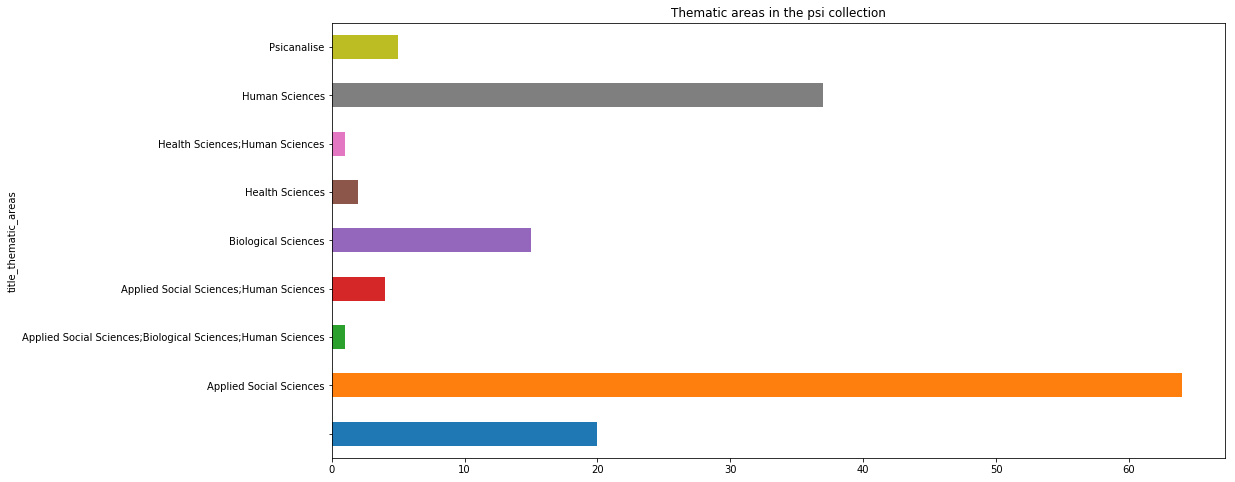

In [13]:
psi_areas = journals[journals["collection"] == "psi"].fillna("") \
                    .groupby("title_thematic_areas").size()
psi_areas.plot.barh(figsize=(16, 8),
                    title="Thematic areas in the psi collection")
psi_areas

The most common classification as `Applied Social Sciences`,
but psychology is instead rooted as `Human Sciences` in the
[Lattes knowledge tree](http://lattes.cnpq.br/web/dgp/arvore-do-conhecimento)
(there's also a
 [full PDF version of it](http://www.cnpq.br/documents/10157/186158/TabeladeAreasdoConhecimento.pdf)
 in CNPq, but both are in Brazilian Portuguese),
which should be seen as a default/fallback for these empty/invalid entries.

## Consistency within the ISSN

We'll need the ISSN, so let's normalize it
by applying the snippet from the ISSN normalization notebook:

In [14]:
issn_scielo_fix = {"0001-6002": "0001-6012",
                   "0258-6444": "2215-3535",
                   "0325-8203": "1668-7027",
                   "0719-448x": "0719-448X",
                   "0797-9789": "1688-499X",
                   "0807-8967": "0870-8967",
                   "0858-6444": "0258-6444",
                   "1315-5216": "1316-5216",
                   "1667-8682": "1667-8982",
                   "1678-5177": "0103-6564",
                   "1683-0789": "1683-0768",
                   "1688-4094": "1688-4221",
                   "1852-4418": "1852-4184",
                   "1980-5438": "0103-5665",
                   "2175-3598": "0104-1282",
                   "2233-7666": "2223-7666",
                   "2237-101X": "1518-3319",
                   "24516600": "2451-6600",
                   "2993-6797": "2393-6797"}
journals["issn_scielo"].replace(issn_scielo_fix, inplace=True)

Each journal might have more than one row,
since it might appear in more than one collection,
but there might be some inconsistency going on, as well.
Repeated rows aren't a big issue,
but every inconsistent duplication needs to be fixed.
Which ISSNs are inconsistent?
That is, which ISSNs
are assigned to distinct thematic areas in distinct rows?

In [15]:
areas_inconsistency = journals[journals[areas].sum(axis=1) != 0] \
                              [["issn_scielo"] + areas] \
    .groupby("issn_scielo") \
    .apply(lambda df: df.apply(lambda col: set(col.dropna()))
                        .apply(len).max() > 1)
areas_inconsistency_index = areas_inconsistency[areas_inconsistency].index
areas_inconsistency_index

Index(['0011-5258', '0100-512X', '0100-8587', '0101-3300', '0101-9074',
       '0102-6909', '0103-2070', '0103-5665', '0104-026X', '0104-4478',
       '0104-7183', '0104-8333', '0104-9313', '0120-0534', '0254-9247',
       '0717-7194', '0718-6924', '1012-1587', '1413-294X', '1413-8271',
       '1414-3283', '1414-753X', '1414-9893', '1517-4522', '1518-3319',
       '1688-4221', '1688-499X', '1794-9998', '1806-6445', '1806-6976',
       '1981-3821', '2215-3535'],
      dtype='object', name='issn_scielo')

In [16]:
pd.DataFrame(
    journals[journals["issn_scielo"].isin(areas_inconsistency_index)]
        .groupby("issn_scielo")
        .apply(lambda df: {k: v for k, v in df[areas].apply(set)
                                                     .to_dict().items()
                                if len(v) > 1})
        .apply(sorted) # Casts from dictionary (keys) to list
        .rename("inconsistency")
)

,inconsistency
issn_scielo,
0011-5258,"[is_applied_social_sciences, is_human_sciences]"
0100-512X,[is_applied_social_sciences]
0100-8587,[is_applied_social_sciences]
0101-3300,[is_applied_social_sciences]
0101-9074,"[is_applied_social_sciences, is_human_sciences]"
0102-6909,"[is_applied_social_sciences, is_human_sciences]"
0103-2070,"[is_applied_social_sciences, is_human_sciences]"
0103-5665,"[is_applied_social_sciences, is_human_sciences]"
0104-026X,[is_applied_social_sciences]


There seems to be way too many inconsistencies,
but let's simply remove the empty entries before checking this.

In [17]:
inconsistencies_df = pd.DataFrame(
    journals[journals["issn_scielo"].isin(areas_inconsistency_index) & 
             journals[areas].sum(axis=1)]
        .groupby("issn_scielo")
        .apply(lambda df: sorted(k for k, v in df[areas].apply(set)
                                                        .to_dict().items()
                                   if len(v) > 1)
                          or None)
        .dropna()
        .rename("inconsistency")
)
inconsistencies_df

,inconsistency
issn_scielo,
0011-5258,"[is_applied_social_sciences, is_human_sciences]"
0101-9074,"[is_applied_social_sciences, is_human_sciences]"
0102-6909,"[is_applied_social_sciences, is_human_sciences]"
0103-2070,"[is_applied_social_sciences, is_human_sciences]"
0103-5665,"[is_applied_social_sciences, is_human_sciences]"
0104-4478,"[is_applied_social_sciences, is_human_sciences]"
0104-7183,"[is_applied_social_sciences, is_human_sciences]"
0120-0534,"[is_biological_sciences, is_human_sciences]"
0254-9247,"[is_applied_social_sciences, is_human_sciences]"


In [18]:
inconsistent_rows = (
    journals
        [journals["issn_scielo"].isin(inconsistencies_df.index)]
        [["issn_scielo", "collection",
          "title_thematic_areas", "title_current_status"]]
        .sort_values(by=["issn_scielo", "collection"])
)
inconsistent_rows.set_index(["issn_scielo", "collection"])

title_thematic_areas title_current_status
issn_scielo collection                                              
0011-5258   scl                  Human Sciences              current
            sss         Applied Social Sciences              current
0101-9074   scl                  Human Sciences              current
            sss         Applied Social Sciences              current
0102-6909   scl                  Human Sciences              current
            sss         Applied Social Sciences              current
0103-2070   scl                  Human Sciences              current
            sss         Applied Social Sciences              current
0103-5665   psi         Applied Social Sciences             deceased
            psi         Applied Social Sciences              current
            scl                  Human Sciences            suspended
0104-4478   scl                  Human Sciences              current
            sss         Applied Social Sciences              current
0104-7183   scl                  Human Sciences              current
            sss         Applied Social Sciences              current
0120-0534   col                  Human Sciences              current
            psi             Biological Sciences            suspended
0254-9247   per                  Human Sciences              current
            psi         Applied Social Sciences              current
0718-6924   chl                  Human Sciences              current
            psi         Applied Social Sciences            suspended
1413-8271   psi         Applied Social Sciences            suspended
            scl                  Human Sciences              current
1414-9893   psi         Applied Social Sciences            suspended
            scl                  Human Sciences              current
1517-4522   scl                  Human Sciences              current
            sss         Applied Social Sciences              current
1518-3319   scl                  Human Sciences              current
            sss         Applied Social Sciences              current
1794-9998   col                  Human Sciences              current
            psi         Applied Social Sciences            suspended
1806-6976   psi         Applied Social Sciences              current
            rve                 Health Sciences            suspended
1981-3821   scl                  Human Sciences              current
            sss         Applied Social Sciences              current

In [19]:
inconsistent_rows.groupby("issn_scielo")["collection"] \
    .apply(set).value_counts()

{sss, scl}    9
{scl, psi}    3
{col, psi}    2
{psi, per}    1
{chl, psi}    1
{rve, psi}    1
Name: collection, dtype: int64

The above show that, internal to each collection,
the thematic area is always consistent in the 2018-09-14 reports.
However, distinct collections sometimes classify some journals differently.
Most entries regarding this issue are from both
the now discontinued `sss` collection (Social Sciences)
and the `scl` collection (Brazil),
in these cases we should stick with the value given by the `scl` collection,
since it's probably the updated value.
The entries with both `psi` and `scl` have
the journal either `suspended` or `deceased` in `psi`,
so we should, also, use the value in the `scl` entry.
The same happen in the pairs `col`-`psi` and `chl`-`psi`.

There's a single entry active in both `psi` and `per`,
but since psychology belongs to the `Human Sciences` area
(as seem in the *Emptiness* section of this notebook),
we should take care when a psychology collection entry
is regarded as `Applied Social Sciences`.
Actually, we should use the thematic area classification
as in the `per` collection, as the journal clearly regards to psychology:

In [20]:
journals[journals["issn_scielo"] == "0254-9247"][[
    "collection", "title_thematic_areas", "title_current_status",
    "title_scielo", "title_subtitle_scielo", "short_title_scielo",
    "title_pubmed", "publisher_name", "short_iso"]].T

,1262,1378
collection,per,psi
title_thematic_areas,Human Sciences,Applied Social Sciences
title_current_status,current,current
title_scielo,Revista de Psicología (PUCP),Revista de Psicología (Lima)
title_subtitle_scielo,Revista de Psicología (PUCP),Revista de Psicología (Lima)
short_title_scielo,Revista de Psicología,Rev. psicol. (Lima)
title_pubmed,NaN,NaN
publisher_name,Pontificia Universidad Católica del Perú,Pontificia Universidad Católica del Perú. Departamento de humanidades
short_iso,Revista de Psicología,Rev. psicol. (Lima)


The only pair missing is the one regarding two thematic collections:

In [21]:
journals[journals["issn_scielo"] == "1806-6976"][[
    "collection", "title_thematic_areas", "title_current_status",
    "title_scielo", "title_subtitle_scielo", "short_title_scielo",
    "title_pubmed", "publisher_name", "short_iso"]].T

,1453,1499
collection,psi,rve
title_thematic_areas,Applied Social Sciences,Health Sciences
title_current_status,current,suspended
title_scielo,SMAD. Revista eletrônica saúde mental álcool e drogas,SMAD. Revista eletrônica saúde mental álcool e drogas
title_subtitle_scielo,SMAD. Revista eletrônica saúde mental álcool e drogas,SMAD. Revista eletrônica saúde mental álcool e drogas
short_title_scielo,"SMAD, Rev. Eletrônica Saúde Mental Álcool Drog. (Ed. port.)","SMAD, Rev. Eletrônica Saúde Mental Álcool Drog. (Ed. port.)"
title_pubmed,NaN,NaN
publisher_name,"Universidade de São Paulo, Escola de Enfermagem de Ribeirão Preto",USP/EERP
short_iso,"SMAD, Rev. Eletrônica Saúde Mental Álcool Drog. (Ed. port.)","SMAD, Rev. Eletrônica Saúde Mental Álcool Drog. (Ed. port.)"


As the journal title translated to English means something like
`Mental health, alcohol and drugs e-journal`,
it's pretty hard to know if it's more about psychology or some health science,
despite the fact that the name might be misleading,
but it might be both,
and there's no `Human Sciences` in either alternative.

The easier approach for this normalization is:
if the journal has *distinct* thematic areas in different collections,
stick with entry in the *certified* and *currently maintained collection*,
or in `rve`.
That suffices in our case,
and it'll choose exactly the entries as discriminated above.

## Normalizing

The goal is copy the fill the empty data as `Human Sciences`,
and use information from a single row when
there's more than one with distinct areas,
leaving the `sss` and `psi` with lower priority
when there's some conflict.
That can be done on the `title_thematic_areas` column:

In [22]:
tta_map = journals.groupby("issn_scielo").apply(
    lambda df: df.assign(title_thematic_areas=df["title_thematic_areas"]
                                              .replace("Psicanalise",
                                                       "Human Sciences")
                                              .fillna("Human Sciences"),
                         order=df["collection"].isin(["sss", "psi"]) |
                               (df["title_thematic_areas"] == "Psicanalise") |
                               df["title_thematic_areas"].isna())
                 .sort_values("order")["title_thematic_areas"].iloc[0]
)
tta_text_n = journals["issn_scielo"].map(tta_map) \
                                    .rename("title_thematic_areas")
tta_text_n.head()

0     Applied Social Sciences
1             Health Sciences
2              Human Sciences
3    Exact and Earth Sciences
4             Health Sciences
Name: title_thematic_areas, dtype: object

It can be used to re-build the several flag columns:

In [23]:
tta_list_n = tta_text_n.str.split(";")
tta_n = pd.DataFrame(tta_text_n).assign(**{
    area: tta_list_n.apply((lambda n: lambda entries: int(n in entries))(name))
    for name, area in areas_map.items()
}).assign(
    is_multidisciplinary=lambda df: (df[areas].sum(axis=1) >= 3).map(int)
)
tta_n.head().T

,0,1,2,3,4
title_thematic_areas,Applied Social Sciences,Health Sciences,Human Sciences,Exact and Earth Sciences,Health Sciences
is_agricultural_sciences,0,0,0,0,0
is_applied_social_sciences,1,0,0,0,0
is_biological_sciences,0,0,0,0,0
is_engineering,0,0,0,0,0
is_exact_earth_sciences,0,0,0,1,0
is_health_sciences,0,1,0,0,1
is_human_sciences,0,0,1,0,0
is_linguistics_letters_arts,0,0,0,0,0
is_multidisciplinary,0,0,0,0,0


Which can be used to directly normalize the dataset:

In [24]:
journals_n = journals.assign(**tta_n)
journals_n.shape

(1732, 98)

How many empty thematic area entries are there?

In [25]:
journals_n[journals_n[areas].sum(axis=1) == 0].shape[0]

0

Are there any ISSN with inconsistent thematic areas?

In [26]:
journals["issn_scielo"].drop_duplicates().shape

(1653,)

In [27]:
journals_n.groupby("issn_scielo")[areas].apply(
    lambda df: len(df.drop_duplicates())
).value_counts()

1    1653
dtype: int64

All distinct ISSNs in this new `journals_n`
have only one set of thematic areas, so it's consistent.

## Summary

A full snippet for thematic area normalization is:

```python
areas_map = {
    "Agricultural Sciences": "is_agricultural_sciences",
    "Applied Social Sciences": "is_applied_social_sciences",
    "Biological Sciences": "is_biological_sciences",
    "Engineering": "is_engineering",
    "Exact and Earth Sciences": "is_exact_earth_sciences",
    "Health Sciences": "is_health_sciences",
    "Human Sciences": "is_human_sciences",
    "Linguistics, Letters and Arts": "is_linguistics_letters_arts",
}
areas = list(areas_map.values())

issn_scielo_fix = {"0001-6002": "0001-6012",
                   "0258-6444": "2215-3535",
                   "0325-8203": "1668-7027",
                   "0719-448x": "0719-448X",
                   "0797-9789": "1688-499X",
                   "0807-8967": "0870-8967",
                   "0858-6444": "0258-6444",
                   "1315-5216": "1316-5216",
                   "1667-8682": "1667-8982",
                   "1678-5177": "0103-6564",
                   "1683-0789": "1683-0768",
                   "1688-4094": "1688-4221",
                   "1852-4418": "1852-4184",
                   "1980-5438": "0103-5665",
                   "2175-3598": "0104-1282",
                   "2233-7666": "2223-7666",
                   "2237-101X": "1518-3319",
                   "24516600": "2451-6600",
                   "2993-6797": "2393-6797"}

def normalize_column_title(name):
    import re
    name_unbracketed = re.sub(r".*\((.*)\)", r"\1",
                              name.replace("(in months)", "in_months"))
    words = re.sub("[^a-z0-9+_ ]", "", name_unbracketed.lower()).split()
    ignored_words = ("at", "the", "of", "and", "google", "scholar", "+")
    replacements = {
        "document": "doc",
        "documents": "docs",
        "frequency": "freq",
        "language": "lang",
    }
    return "_".join(replacements.get(word, word)
                    for word in words if word not in ignored_words) \
              .replace("title_is", "is")

# Load the data
journals = pd.read_csv("tabs_network/journals.csv")

# Column names and ISSN normalization
journals.rename(columns=normalize_column_title, inplace=True)
journals["issn_scielo"].replace(issn_scielo_fix, inplace=True)

# Thematic area normalization
tta_map = journals.groupby("issn_scielo").apply(
    lambda df: df.assign(title_thematic_areas=df["title_thematic_areas"]
                                              .replace("Psicanalise",
                                                       "Human Sciences")
                                              .fillna("Human Sciences"),
                         order=df["collection"].isin(["sss", "psi"]) |
                               (df["title_thematic_areas"] == "Psicanalise") |
                               df["title_thematic_areas"].isna())
                 .sort_values("order")["title_thematic_areas"].iloc[0]
)
tta_text_n = journals["issn_scielo"].map(tta_map) \
                                    .rename("title_thematic_areas")
tta_list_n = tta_text_n.str.split(";")
tta_n = pd.DataFrame(tta_text_n).assign(**{
    area: tta_list_n.apply((lambda n: lambda entries: int(n in entries))(name))
    for name, area in areas_map.items()
}).assign(
    is_multidisciplinary=lambda df: (df[areas].sum(axis=1) >= 3).map(int)
)
journals = journals.assign(**tta_n)
```

It also normalizes the column names and the `issn_scielo` column
(former `ISSN SciELO`),
as these are a requirement in order to normalize the thematic areas.